## Data Collection

Daily Data was collecting from 01-01-1990 to 31-12-2023.

Data Source: [open-meteo](https://open-meteo.com/en/docs/historical-weather-api) API

#### API Call

In [94]:
import openmeteo_requests
import requests_cache
from retry_requests import retry
import numpy as np
import pandas as pd

In [2]:
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
    "latitude": 13.08,
    "longitude": 80.27,
    "start_date": "2023-01-01",
    "end_date": "2024-01-01",
    "daily":  ["temperature_2m_max", "temperature_2m_min", "precipitation_sum", "wind_speed_10m_max", "wind_gusts_10m_max", "wind_direction_10m_dominant"],
    "timezone": "auto"
}
api_response = openmeteo.weather_api(url, params=params)
response = api_response[0]

In [3]:
daily = response.Daily()
daily_data = {"date": pd.date_range(
    start = pd.to_datetime(daily.Time(), unit = "s"),
    end = pd.to_datetime(daily.TimeEnd(), unit = "s"),
    freq = pd.Timedelta(seconds = daily.Interval()),
    inclusive = "left"
)}
daily_data["temperature_2m_max"] = daily.Variables(0).ValuesAsNumpy()
daily_data["temperature_2m_min"] = daily.Variables(1).ValuesAsNumpy()
daily_data["precipitation_sum"] = daily.Variables(2).ValuesAsNumpy()
daily_data["wind_speed_10m_max"] = daily.Variables(3).ValuesAsNumpy()
daily_data["wind_gusts_10m_max"] = daily.Variables(4).ValuesAsNumpy()
daily_data["wind_direction_10m_dominant"] = daily.Variables(5).ValuesAsNumpy()
daily_dataframe = pd.DataFrame(data = daily_data)

In [4]:
daily_dataframe

,date,temperature_2m_max,temperature_2m_min,precipitation_sum,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant
0,2022-12-31 18:30:00,28.549999,21.299999,0.0,13.004921,25.919998,64.204056
1,2023-01-01 18:30:00,28.200001,21.799999,0.1,9.605998,23.759998,84.407700
2,2023-01-02 18:30:00,27.799999,22.000000,0.3,17.709658,36.000000,52.628098
3,2023-01-03 18:30:00,27.600000,22.000000,1.9,16.735161,34.200001,61.804401
4,2023-01-04 18:30:00,28.500000,25.000000,0.0,22.226902,43.199997,60.063496
...,...,...,...,...,...,...,...
361,2023-12-27 18:30:00,28.350000,24.250000,2.0,22.657131,43.560001,34.596729
362,2023-12-28 18:30:00,28.350000,24.250000,2.0,23.863411,45.360001,41.633450
363,2023-12-29 18:30:00,28.299999,23.900000,0.9,18.792549,36.360001,37.787354
364,2023-12-30 18:30:00,28.100000,23.250000,0.2,17.566378,35.639999,44.479641


## Data Preparation

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [60]:
daily_weather_data = pd.read_csv("data/1990-2023-data.csv")
daily_weather_data = daily_weather_data.iloc[:, 1:]

In [61]:
daily_weather_data.shape

(211106, 12)

In [62]:
daily_weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211106 entries, 0 to 211105
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   date                         211106 non-null  object 
 1   city_name                    211106 non-null  object 
 2   temperature_2m_max           211106 non-null  float64
 3   temperature_2m_min           211106 non-null  float64
 4   temperature_2m_mean          211106 non-null  float64
 5   precipitation_sum            211106 non-null  float64
 6   precipitation_hours          211106 non-null  int64  
 7   wind_speed_10m_max           211106 non-null  float64
 8   wind_gusts_10m_max           211106 non-null  float64
 9   wind_direction_10m_dominant  211106 non-null  float64
 10  et0_fao_evapotranspiration   211105 non-null  float64
 11  precipitation_forecast       211106 non-null  float64
dtypes: float64(9), int64(1), object(2)
memory usage: 19.3+ MB


#### Handling null values

In [63]:
daily_weather_data.isnull().sum()

date                           0
city_name                      0
temperature_2m_max             0
temperature_2m_min             0
temperature_2m_mean            0
precipitation_sum              0
precipitation_hours            0
wind_speed_10m_max             0
wind_gusts_10m_max             0
wind_direction_10m_dominant    0
et0_fao_evapotranspiration     1
precipitation_forecast         0
dtype: int64

In [64]:
daily_weather_data[daily_weather_data["et0_fao_evapotranspiration"].isnull()]

,date,city_name,temperature_2m_max,temperature_2m_min,temperature_2m_mean,precipitation_sum,precipitation_hours,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,et0_fao_evapotranspiration,precipitation_forecast
11767,21-03-2022,Chennai,33.2,27.15,29.5625,0.0,0,14.707222,34.92,125.332726,NaN,0.5


In [65]:
daily_weather_data["et0_fao_evapotranspiration"] = daily_weather_data["et0_fao_evapotranspiration"].fillna(daily_weather_data["et0_fao_evapotranspiration"].mean()).infer_objects(copy=False)

In [66]:
daily_weather_data.describe()

,temperature_2m_max,temperature_2m_min,temperature_2m_mean,precipitation_sum,precipitation_hours,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,et0_fao_evapotranspiration,precipitation_forecast
count,211106.000000,211106.000000,211106.000000,211106.000000,211106.000000,211106.000000,211106.000000,211106.000000,211106.000000,211106.000000
mean,30.451096,24.166130,26.927572,5.021290,6.462914,16.751079,34.778268,212.876876,4.263624,5.022515
std,2.839966,2.240474,2.077805,11.034945,7.989166,5.234025,9.215079,98.861939,1.315122,11.035946
min,19.800000,11.119500,17.177834,0.000000,0.000000,3.259939,10.440001,0.000005,0.414433,0.000000
25%,28.295000,23.147500,25.516413,0.000000,0.000000,13.004921,28.080000,147.181615,3.436586,0.000000
50%,30.150000,24.214500,26.596250,0.500000,2.000000,16.263872,33.839996,236.721500,4.266765,0.500000
75%,32.305500,25.543499,28.250837,5.100000,11.000000,19.995400,39.960000,296.564970,5.145306,5.100001
max,44.839000,34.293500,37.491413,445.199980,24.000000,70.207380,150.480000,360.000000,10.681978,445.199980


##### Rainfall distribution in each month

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, '1.0'),
  Text(1, 0, '2.0'),
  Text(2, 0, '3.0'),
  Text(3, 0, '4.0'),
  Text(4, 0, '5.0'),
  Text(5, 0, '6.0'),
  Text(6, 0, '7.0'),
  Text(7, 0, '8.0'),
  Text(8, 0, '9.0'),
  Text(9, 0, '10.0'),
  Text(10, 0, '11.0'),
  Text(11, 0, '12.0')])

<Figure size 1200x1200 with 0 Axes>

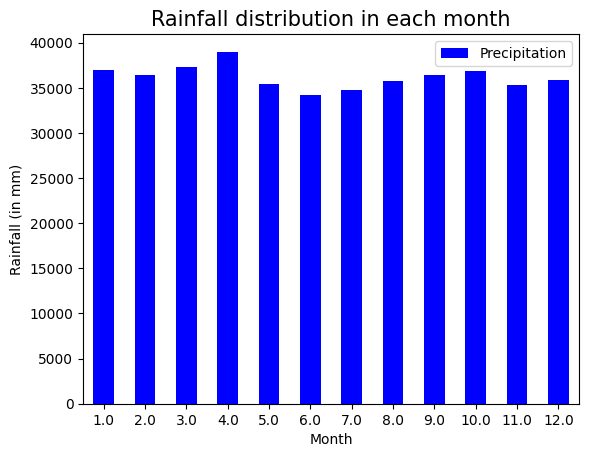

In [51]:
daily_weather_data['date'] = pd.to_datetime(daily_weather_data['date'], errors='coerce')
rainfall = [daily_weather_data['date'].dt.year, daily_weather_data['date'].dt.month, daily_weather_data['precipitation_forecast']]
headers = ['Year', 'Month', 'Precipitation']
rainfall_df = pd.concat(rainfall, axis=1, keys=headers)
plt.figure(figsize=(12,12))
a = rainfall_df.groupby('Month').agg({'Precipitation':'sum'})
a.plot(kind='bar', color='blue')
plt.title('Rainfall distribution in each month', fontsize=15)
plt.xlabel('Month', fontsize=10)
plt.ylabel('Rainfall (in mm)', fontsize=10)
plt.xticks(rotation=0)

##### Correlation between attributes

<Axes: >

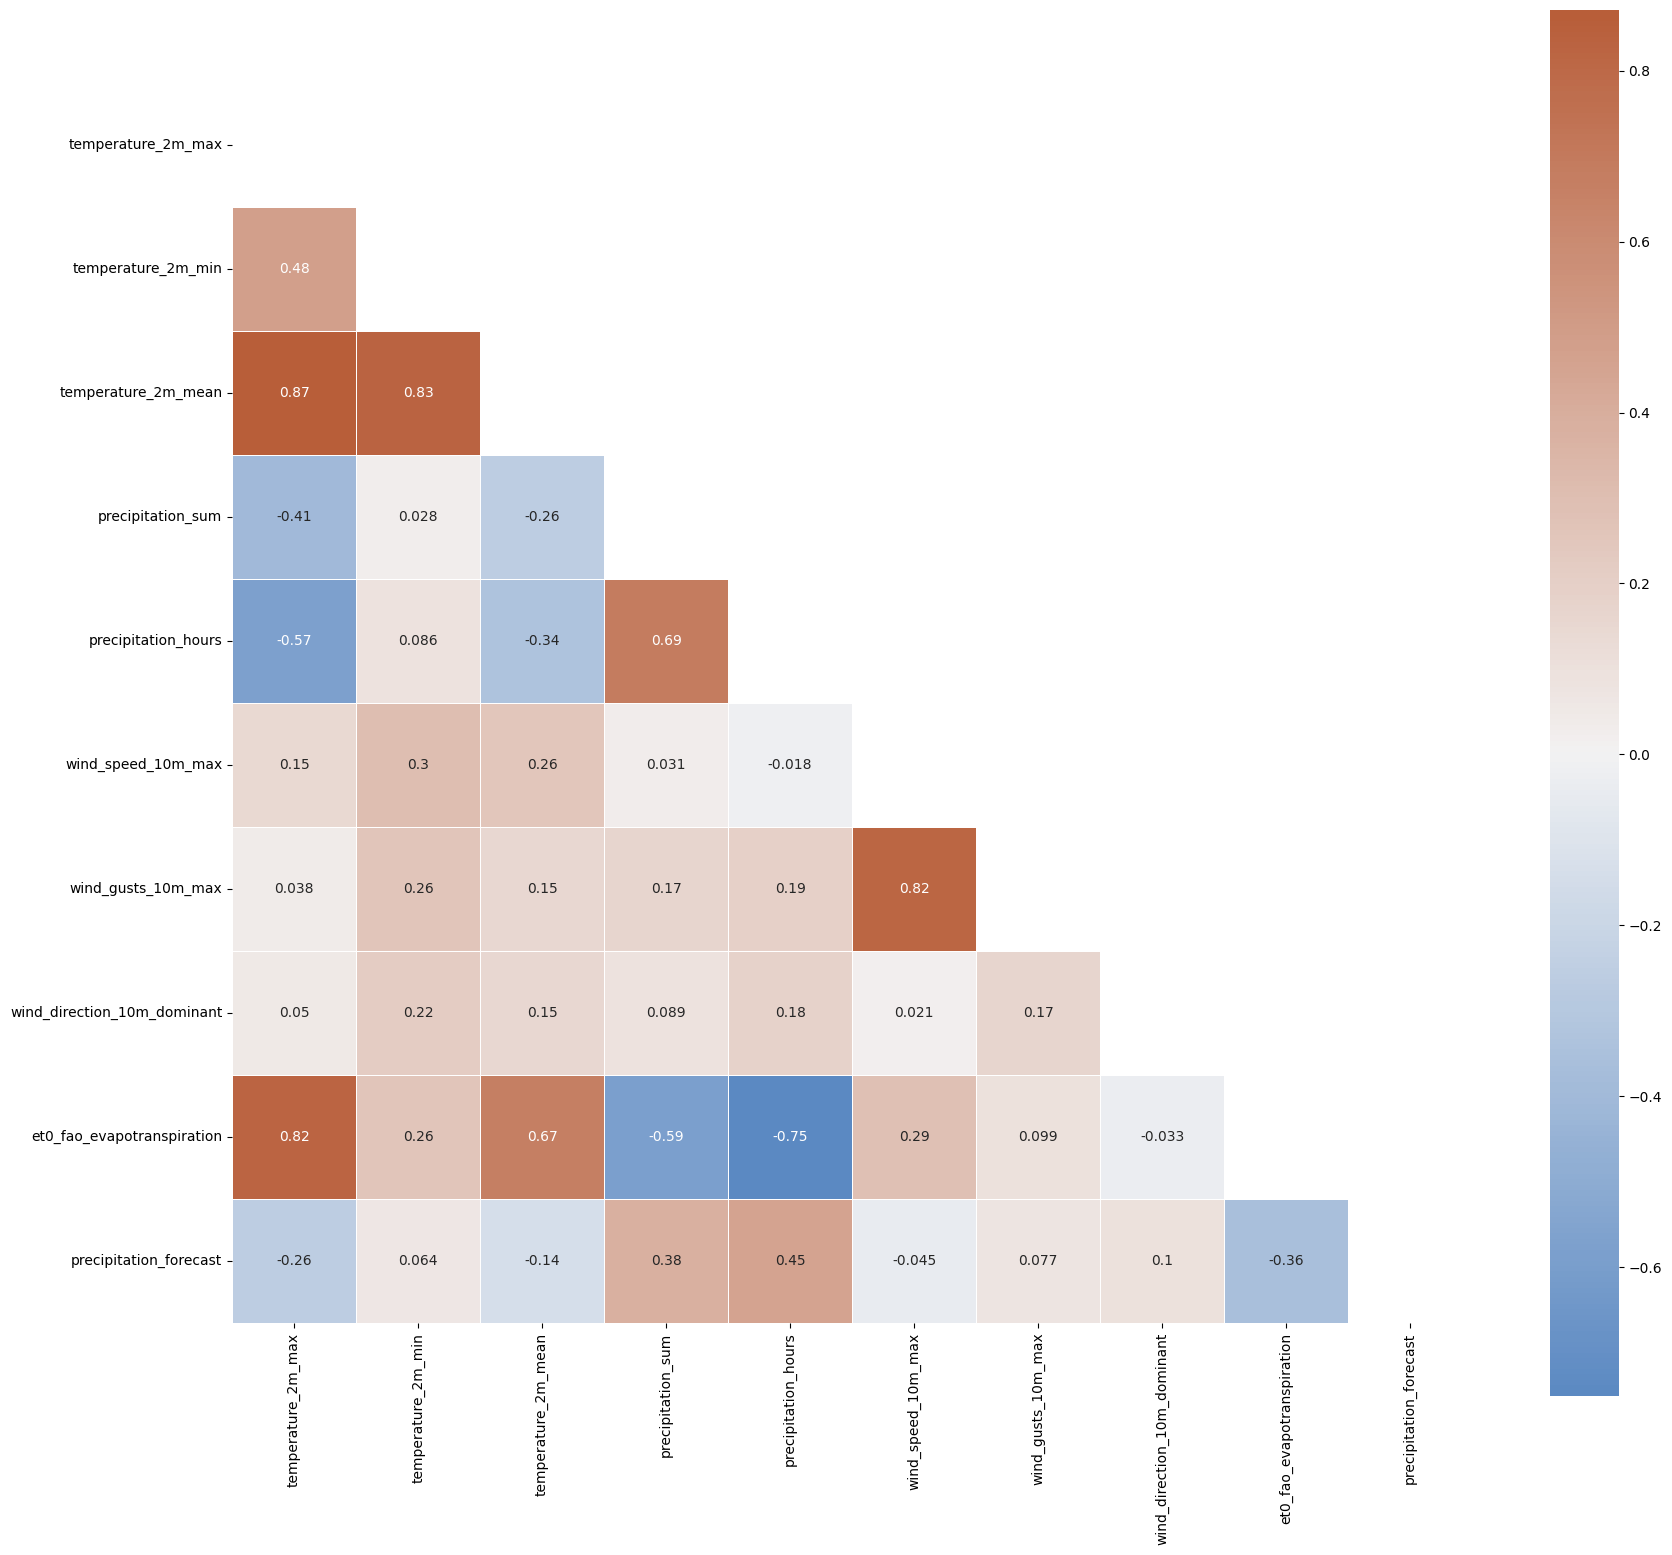

In [10]:
corr = daily_weather_data.iloc[:, 2:].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
fig, ax =plt.subplots(figsize=(20, 20))
cmap = sns.diverging_palette(250, 25, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, annot=True, vmax=None, center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.9})

##### Rainfall vs City plot 

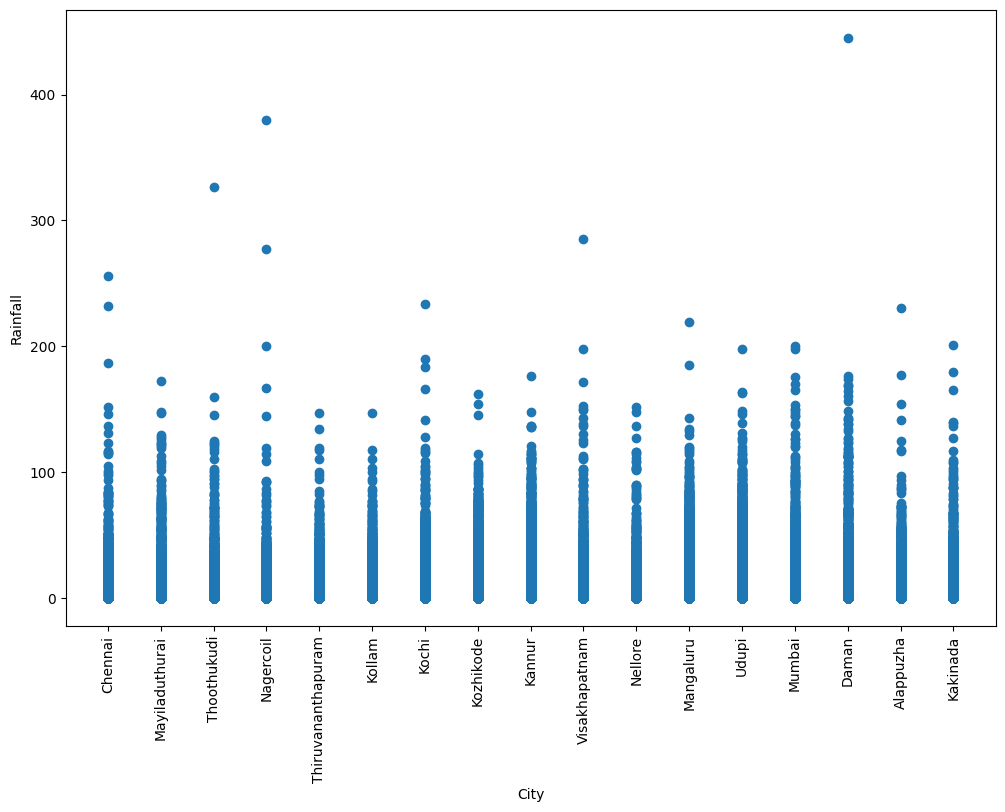

In [11]:
plt.figure(figsize=(12, 8))
plt.scatter(daily_weather_data['city_name'], daily_weather_data["precipitation_sum"])
plt.xlabel("City")
plt.xticks(rotation=90)
plt.ylabel("Rainfall")
plt.show()

#### Encoding

In [67]:
daily_weather_data.select_dtypes(include=["object"]).columns

Index(['date', 'city_name'], dtype='object')

City name encoding

In [68]:
from sklearn.preprocessing import LabelEncoder
cityEncoder = LabelEncoder()
daily_weather_data['city_name'] = cityEncoder.fit_transform(daily_weather_data['city_name'])

In [69]:
daily_weather_data['city_name'].unique()

array([ 1,  9, 14, 11, 13,  6,  5,  7,  4, 16, 12,  8, 15, 10,  2,  0,  3])

Date encoding (Cyclical Encoding)

In [70]:
def date_encoder(dataset):
    dataset['date'] = pd.to_datetime(dataset['date'], format='%d-%m-%Y')
    df_encode = dataset.copy()
    df_encode['day_of_year'] = df_encode['date'].dt.dayofyear
    for i in df_encode['day_of_year']:
        df_encode['day_of_year_sin'] = np.sin(2 * np.pi * i / 366)
        df_encode['day_of_year_cos'] = np.cos(2 * np.pi * i / 366)
    dataset = pd.concat([dataset['city_name'], df_encode[['day_of_year_sin', 'day_of_year_cos']],
                    dataset[['temperature_2m_max','temperature_2m_min', 'temperature_2m_mean', 'precipitation_sum','precipitation_hours','wind_speed_10m_max','wind_gusts_10m_max','wind_direction_10m_dominant','et0_fao_evapotranspiration','precipitation_forecast']]], axis=1)
    return dataset

In [71]:
daily_weather_data.head(1)

,date,city_name,temperature_2m_max,temperature_2m_min,temperature_2m_mean,precipitation_sum,precipitation_hours,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,et0_fao_evapotranspiration,precipitation_forecast
0,01-01-1990,1,27.35,22.3,24.595833,0.1,1,17.429354,30.960001,51.675465,3.471187,0.0


In [72]:
daily_weather_data = date_encoder(daily_weather_data)

In [73]:
daily_weather_data.head(1)

,city_name,day_of_year_sin,day_of_year_cos,temperature_2m_max,temperature_2m_min,temperature_2m_mean,precipitation_sum,precipitation_hours,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,et0_fao_evapotranspiration,precipitation_forecast
0,1,-0.017166,0.999853,27.35,22.3,24.595833,0.1,1,17.429354,30.960001,51.675465,3.471187,0.0


### Train Test split

In [74]:
features = daily_weather_data[['city_name', 'day_of_year_sin','day_of_year_cos', 'temperature_2m_max',
       'temperature_2m_min', 'temperature_2m_mean', 'precipitation_sum',
       'precipitation_hours', 'wind_speed_10m_max', 'wind_gusts_10m_max',
       'wind_direction_10m_dominant', 'et0_fao_evapotranspiration']]

target = daily_weather_data[["precipitation_forecast"]]

In [75]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20, random_state=123)

In [76]:
len(X_train), len(X_test), len(y_train), len(y_test)

(168884, 42222, 168884, 42222)

In [77]:
type(X_train), type(X_test), type(y_train), type(y_test)

(pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame,
 pandas.core.frame.DataFrame)

In [78]:
X_train = X_train.to_numpy(dtype=float)
y_train = y_train.to_numpy(dtype=float)
X_test = X_test.to_numpy(dtype=float)
y_test = y_test.to_numpy(dtype=float)

### Feature Scaling

In [79]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test= scaler.transform(X_test)
#scaler_y = StandardScaler()
#y_train = scaler_y.fit_transform(y_train)
#y_test = scaler_y.fit_transform(y_test)

In [80]:
X_train

array([[-2.05161575e-01,  6.93889390e-18,  4.44089210e-16, ...,
        -2.56313542e-01,  1.05612275e+00,  6.13052679e-02],
       [ 4.07580244e-01,  6.93889390e-18,  4.44089210e-16, ...,
        -6.09001058e-02,  2.85960859e-01,  8.17748697e-01],
       [ 1.02032206e+00,  6.93889390e-18,  4.44089210e-16, ...,
         1.18974417e+00,  1.08806932e+00, -2.42972898e-01],
       ...,
       [ 2.03332971e-01,  6.93889390e-18,  4.44089210e-16, ...,
         1.73595757e-01, -1.41556268e-01,  1.18764342e+00],
       [ 1.22456934e+00,  6.93889390e-18,  4.44089210e-16, ...,
        -1.07704885e+00,  2.17307962e-01,  8.56760826e-01],
       [ 2.03332971e-01,  6.93889390e-18,  4.44089210e-16, ...,
         1.73595757e-01, -1.98296575e+00,  3.34471873e-01]])

In [81]:
X_test

array([[ 6.11827517e-01,  6.93889390e-18,  4.44089210e-16, ...,
         2.20589302e+00,  7.72880092e-01,  4.96420560e-01],
       [ 1.63306388e+00,  6.93889390e-18,  4.44089210e-16, ...,
        -2.56313542e-01,  3.99956114e-01,  9.17552000e-01],
       [-8.17903394e-01,  6.93889390e-18,  4.44089210e-16, ...,
         1.50240565e+00,  6.72503532e-01,  8.05468000e-01],
       ...,
       [-6.13656121e-01,  6.93889390e-18,  4.44089210e-16, ...,
        -2.95396295e-01,  9.69370243e-01,  2.45849971e-01],
       [ 1.22456934e+00,  6.93889390e-18,  4.44089210e-16, ...,
         1.26790979e+00, -4.33915355e-02,  1.23781853e+00],
       [ 8.16074790e-01,  6.93889390e-18,  4.44089210e-16, ...,
        -9.99831839e-02, -6.16770491e-01,  1.39743439e+00]])

### Model Selection

Mutli Linear Regression

In [82]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [83]:
y_pred = regressor.predict(X_test)
y_pred

array([[3.22114477],
       [3.34673117],
       [1.10027868],
       ...,
       [5.58870835],
       [2.82544916],
       [0.93556883]])

In [84]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred)

93.31427780053968

### Ridge Regression

In [85]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=0.3)
ridge.fit(X_train, y_train)

Ridge(alpha=0.3)

In [86]:
y_pred = ridge.predict(X_test)
y_pred

array([[3.22114411],
       [3.34673798],
       [1.10029534],
       ...,
       [5.58869761],
       [2.82544946],
       [0.93554764]])

In [87]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred)

93.31427552972626

### Lasso Regression

In [88]:
from sklearn import linear_model
reg = linear_model.Lasso(alpha=0.1)
reg.fit(X_train, y_train)

Lasso(alpha=0.1)

In [89]:
y_pred = reg.predict(X_test)
y_pred

array([2.79977272, 3.09123337, 0.874051  , ..., 5.05671251, 2.76639759,
       0.98972319])

In [91]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred)

93.49211478232272

### SVR

In [ ]:
from sklearn.svm import SVR
svr_rbf = SVR(kernel='rbf')
svr_rbf.fit(X_train, y_train)

SVR()

In [ ]:
y_pred = svr_rbf.predict(X_test)
y_pred

array([0.33283387, 0.29287207, 0.08381932, ..., 1.8518336 , 0.41865271,
       0.10091582])

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred)

100.22964691822185

## Saving Model

In [92]:
import joblib
joblib.dump(cityEncoder, "MLModel\CityEncoder_2.pkl")
joblib.dump(scaler, "MLModel\StandardScaler_2.pkl")
joblib.dump(regressor, "MLModel\MLR_2.pkl")

['MLModel\\MLR_2.pkl']